# File description
The dataset contains CAPTCHA images. The images are **5 letter** words, and have noise applied (blur and a line). They are of size **200 x 50**. The file name is same as the image letters.

# Aim
Recognize the captcha letters.

# Approach
My approach is to train a **CNN** model for every letter that occurs in the **CAPTCHA** and use this model for evaluation. We will remove all noises (ie. smooth out the images and remove that lines) and then separate out each of the 5 letters in the image and feed each one to the model independently.


# Image procesing

In [116]:
import cv2
import pandas
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [117]:
path1 = '/kaggle/input/jodhpur/111J8.jpg'
path2 = '/kaggle/input/jodhpur/111XM.jpg'

In [118]:
def plot_ (img1, img2) :
    plt.figure(figsize = (20,5))
    
    plt.subplot(1,2,1)
    plt.imshow(img1, 'gray')
    
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(img2, 'gray')
    
    plt.axis('off')

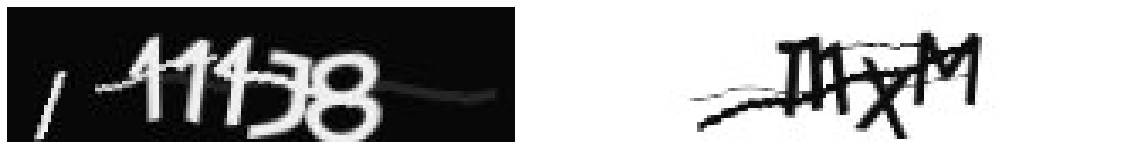

In [119]:
img1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)

if img1 is None or img2 is None:
    print("Error: Could not read images")
else:
    plot_(img1, img2)


### Adaptive Thresholding
Algorithms determine the threshold for a pixel based on its surrounding regions. So we get different thresholds for different regions of the same image which gives better result for images with varying illumination.

In [120]:
thresh_img1 = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
thresh_img2 = cv2.adaptiveThreshold(img2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

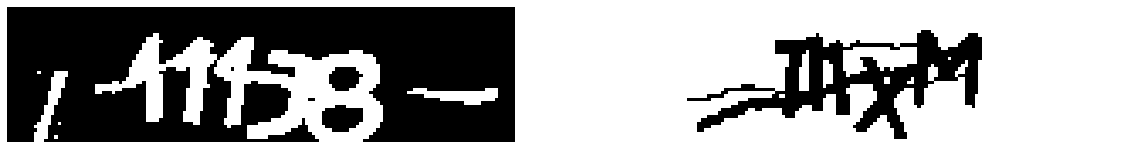

In [121]:
plot_(thresh_img1, thresh_img2)

### Closing
Dilation followed by Erosion.

In [122]:
close_img1 = cv2.morphologyEx(thresh_img1, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))
close_img2 = cv2.morphologyEx(thresh_img2, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))

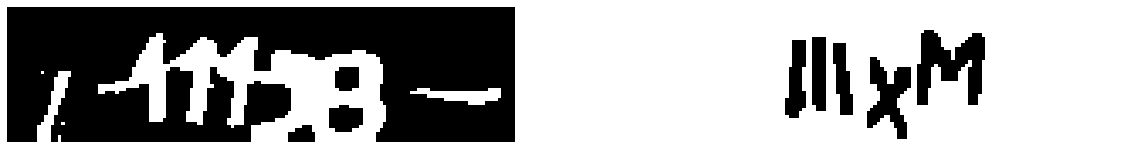

In [123]:
plot_(close_img1, close_img2)

### Dilation
Involves a kernel being scanned over the entire image. The maximal pixel value is calculated in the kernel region and the anchor point of the kernel is updated to that value. This causes the white region to expand in the image.

In [124]:
dilate_img1 = cv2.dilate(close_img1, np.ones((2,2), np.uint8), iterations = 1)
dilate_img2 = cv2.dilate(close_img2, np.ones((2,2), np.uint8), iterations = 1)

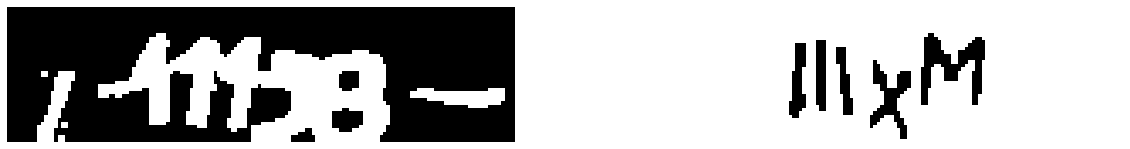

In [125]:
plot_(dilate_img1, dilate_img2)

### Smoothing Images (Blurring)
Involves convolving a low-pass filter with an image, to remove high frequency components ie. noises and edges from the image.

In [126]:
gauss_img1 = cv2.GaussianBlur(dilate_img1, (1,1), 0)
gauss_img2 = cv2.GaussianBlur(dilate_img2, (1,1), 0)

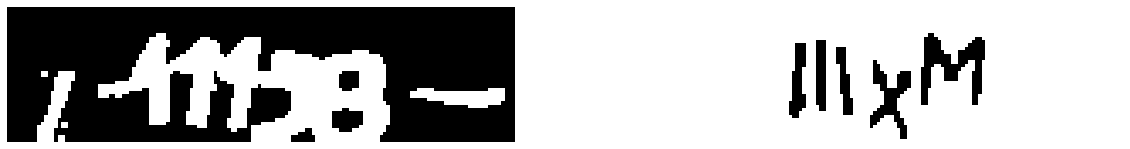

In [127]:
plot_(gauss_img1, gauss_img2)

### PartitioningBatchNormalization

In [128]:
cv2.rectangle(gauss_img1, (30,12), (50,49), 0, 1)
cv2.rectangle(gauss_img1, (50,12), (70,49), 0, 1)
cv2.rectangle(gauss_img1, (70,12), (90,49), 0, 1)
cv2.rectangle(gauss_img1, (90,12), (110,49),0, 1)
cv2.rectangle(gauss_img1, (110,12),(130,49),0, 1)

cv2.rectangle(gauss_img2, (30,12), (50,49), 0, 1)
cv2.rectangle(gauss_img2, (50,12), (70,49), 0, 1)
cv2.rectangle(gauss_img2, (70,12), (90,49), 0, 1)
cv2.rectangle(gauss_img2, (90,12), (110,49),0, 1)
cv2.rectangle(gauss_img2, (110,12),(130,49),0, 1)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

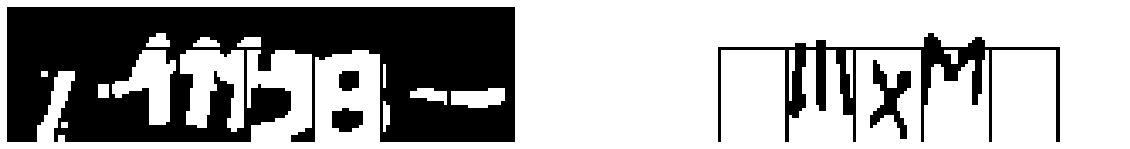

In [129]:
plot_(gauss_img1, gauss_img2)

# Converting images to appropriate samples

In [130]:
path = '/kaggle/input/jodhpur'

In [131]:
def t_img (img) :
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

def c_img (img) :
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))

def d_img (img) :
    return cv2.dilate(img, np.ones((2,2), np.uint8), iterations = 1)

def b_img (img) :
    return cv2.GaussianBlur(img, (1,1), 0)

In [132]:
import os
from PIL import Image
from keras.preprocessing.image import img_to_array, ImageDataGenerator

In [133]:
X = []
y = []

for image in os.listdir(path) :
    
    if image[6:] != 'jpg' :
        continue
    
    img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
    
    img = t_img(img)
    img = c_img(img)
    img = d_img(img)
    img = b_img(img)
    
    image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
    
    for i in range(5) :
        X.append(img_to_array(Image.fromarray(image_list[i])))
        y.append(image[i])
X = np.array(X)
y = np.array(y)

In [134]:
print(X.shape)
print(y.shape)

(565310, 30, 20, 1)
(565310,)


# Initial Analysis and Data Wrangling

### Scale b/w 0 and 1

In [135]:
X /= 255.0

[]

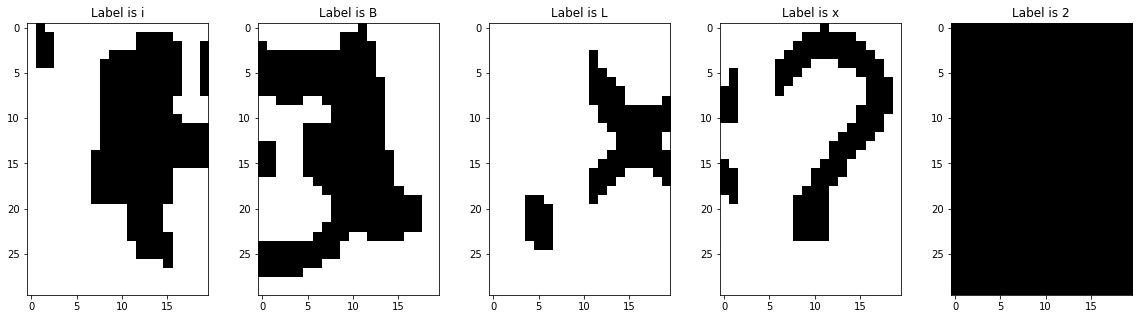

In [136]:
plt.figure(figsize = (20,5))
for i in range(5) :
    plt.subplot(1,5,i+1)
    plt.imshow(X[i], 'gray')
    plt.title('Label is ' + str(y[i]))
plt.plot()

In [137]:
temp = set(y)
for t in temp :
    print('Occurance count of ' + t + ' : ' + str(len(y[y == t])))

Occurance count of S : 9391
Occurance count of f : 9344
Occurance count of 8 : 9421
Occurance count of V : 9332
Occurance count of 9 : 9435
Occurance count of U : 9549
Occurance count of 4 : 9501
Occurance count of h : 9294
Occurance count of m : 9544
Occurance count of a : 9381
Occurance count of u : 9463
Occurance count of H : 9522
Occurance count of q : 9231
Occurance count of s : 9540
Occurance count of F : 9538
Occurance count of b : 9297
Occurance count of v : 9598
Occurance count of 3 : 9465
Occurance count of X : 9456
Occurance count of R : 9459
Occurance count of T : 9469
Occurance count of L : 9459
Occurance count of W : 9501
Occurance count of N : 9324
Occurance count of t : 9355
Occurance count of i : 9471
Occurance count of Z : 9367
Occurance count of B : 9466
Occurance count of g : 9399
Occurance count of J : 9483
Occurance count of z : 9489
Occurance count of C : 9432
Occurance count of 1 : 9550
Occurance count of k : 9327
Occurance count of A : 9410
Occurance count of Y

In [138]:
 temp_df = pandas.DataFrame({'labels' : [t for t in temp], 'Count' : [len(y[y==t]) for t in temp]})

Text(0.5, 1.0, 'Label distribution in CAPTCHAS')

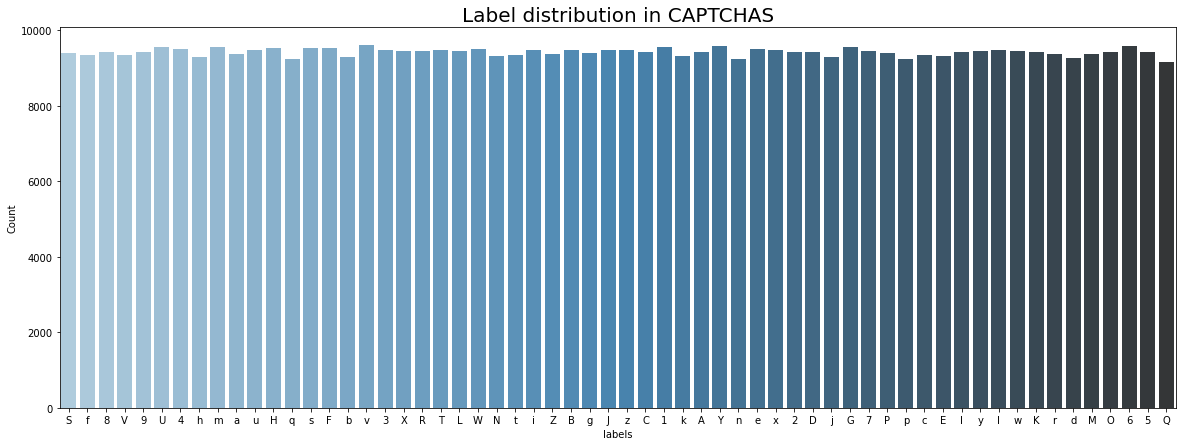

In [139]:
plt.figure(figsize = (20,7))
seaborn.barplot(x = 'labels', y = 'Count', data = temp_df, palette = 'Blues_d')
plt.title('Label distribution in CAPTCHAS', fontsize = 20)

The count of label **n** is almost twice as any other label, so more samples of this letter will be put in the test set.

### One hot encoding

In [140]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

y_combine = LabelEncoder().fit_transform(y)
y_one_hot = OneHotEncoder(sparse = False).fit_transform(y_combine.reshape(len(y_combine),1))

In [141]:
print('letter n : ' + str(y[1]))
print('label : ' + str(y_combine[1]))
print('Count : ' + str(len(y_combine[y_combine == y_combine[1]])))

letter n : B
label : 10
Count : 9466


In [142]:
info = {y_combine[i] : y[i] for i in range(len(y))}

# Train test split

In [143]:
print(X.shape)
print(y_one_hot.shape)  # one hot encoded form

(565310, 30, 20, 1)
(565310, 60)


In [144]:
from sklearn.model_selection import train_test_split

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.2, random_state = 1)

In [146]:
y_temp = np.argmax(y_test, axis = 1)

In [147]:
temp = set(y_temp)
temp_df = pandas.DataFrame({'labels' : [info[t] for t in temp], 'Count' : [len(y_temp[y_temp == t]) for t in temp]})

Text(0.5, 1.0, 'Label distribution in test set')

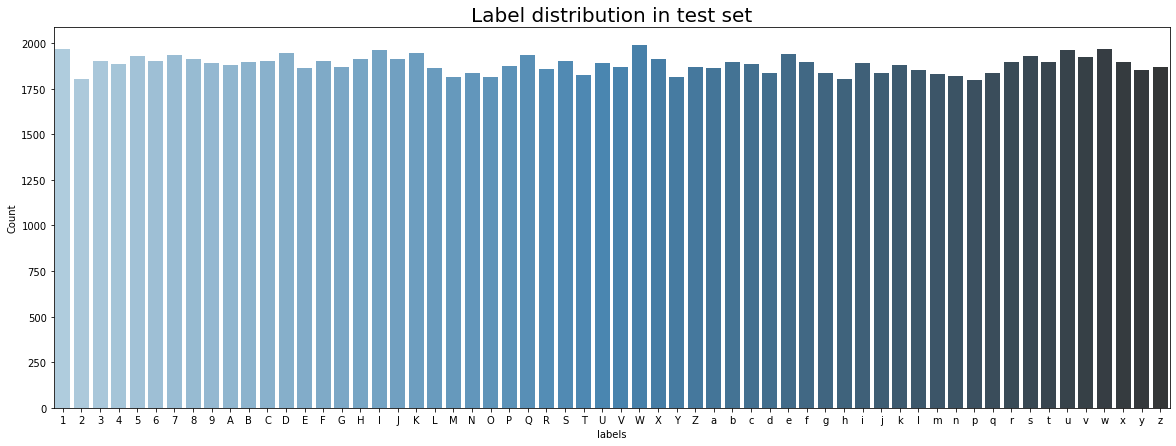

In [148]:
plt.figure(figsize = (20,7))
seaborn.barplot(x = 'labels', y = 'Count', data = temp_df, palette = 'Blues_d')
plt.title('Label distribution in test set', fontsize = 20)

# Model Creation

In [149]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization

from keras.layers import Dropout
from keras.layers import Input

In [150]:
print(X_train.shape)
print(y_train.shape)

(452248, 30, 20, 1)
(452248, 60)


In [151]:
print(X_test.shape)
print(y_test.shape)

(113062, 30, 20, 1)
(113062, 60)


In [152]:
def conv_layer (filterx) :
    
    model = Sequential()
    
    model.add(Conv2D(filterx, (3,3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    
    return model

In [153]:
def dens_layer (hiddenx) :
    
    model = Sequential()
    
    model.add(Dense(hiddenx, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    return model

In [154]:
def cnn (filter1, filter2, filter3, hidden1, hidden2) :
    
    model = Sequential()
    model.add(Input((30, 20, 1,)))
    
    model.add(conv_layer(filter1))
    model.add(conv_layer(filter2))
    model.add(conv_layer(filter3))
    
    model.add(Flatten())
    model.add(dens_layer(hidden1))
    model.add(dens_layer(hidden2))
    
    model.add(Dense(60, activation = 'softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

# Data augmentation and Oversampling

### SMOTE

In [155]:
X_train = np.reshape(X_train, (452248, 600))


In [156]:
y_train.shape

(452248, 60)

In [157]:
from imblearn.over_sampling import SMOTE
X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state = 1).fit_resample(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [158]:
print(X_train.shape)
print(y_train.shape)

(465420, 600)
(465420, 60)


In [159]:
X_train = np.reshape(X_train, (465420, 30, 20, 1))

Oversampled images

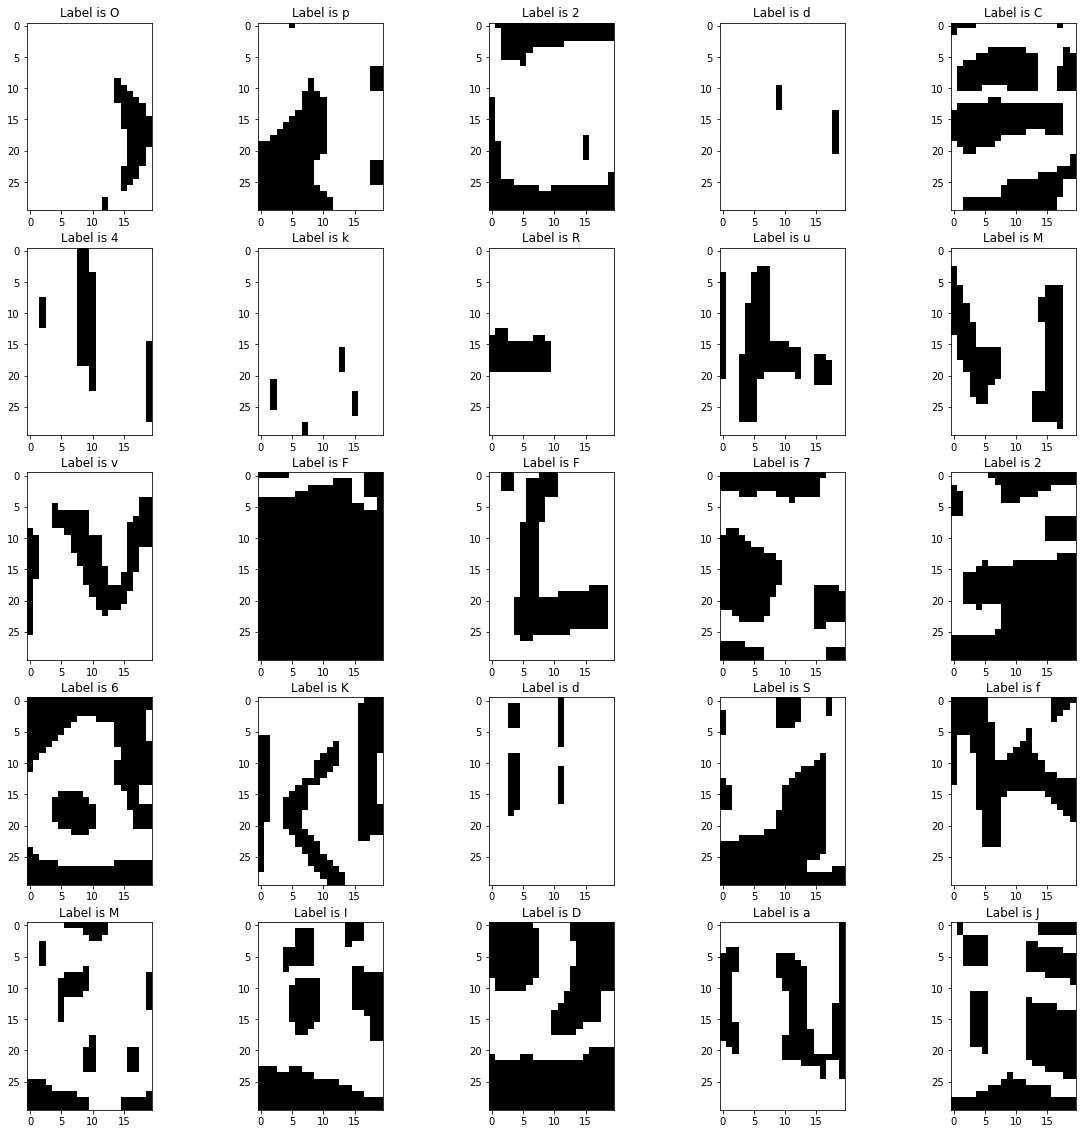

In [160]:
plt.figure(figsize = (20,20))

hi = 7800
lo = 5000

for i in range(25) :
    plt.subplot(5,5,i+1)
    x = np.random.randint(lo, hi)
    plt.imshow(X_train[x], 'gray')
    plt.title('Label is ' + str(info[np.argmax(y_train[x])]))
plt.show()

### ImageDataGenerator

In [161]:
traingen = ImageDataGenerator(rotation_range = 5, width_shift_range = [-2,2])
traingen.fit(X_train)

In [162]:
train_set = traingen.flow(X_train, y_train)

In [163]:
trainX, trainy = train_set.next()

Augmented images with rotations and shifts.

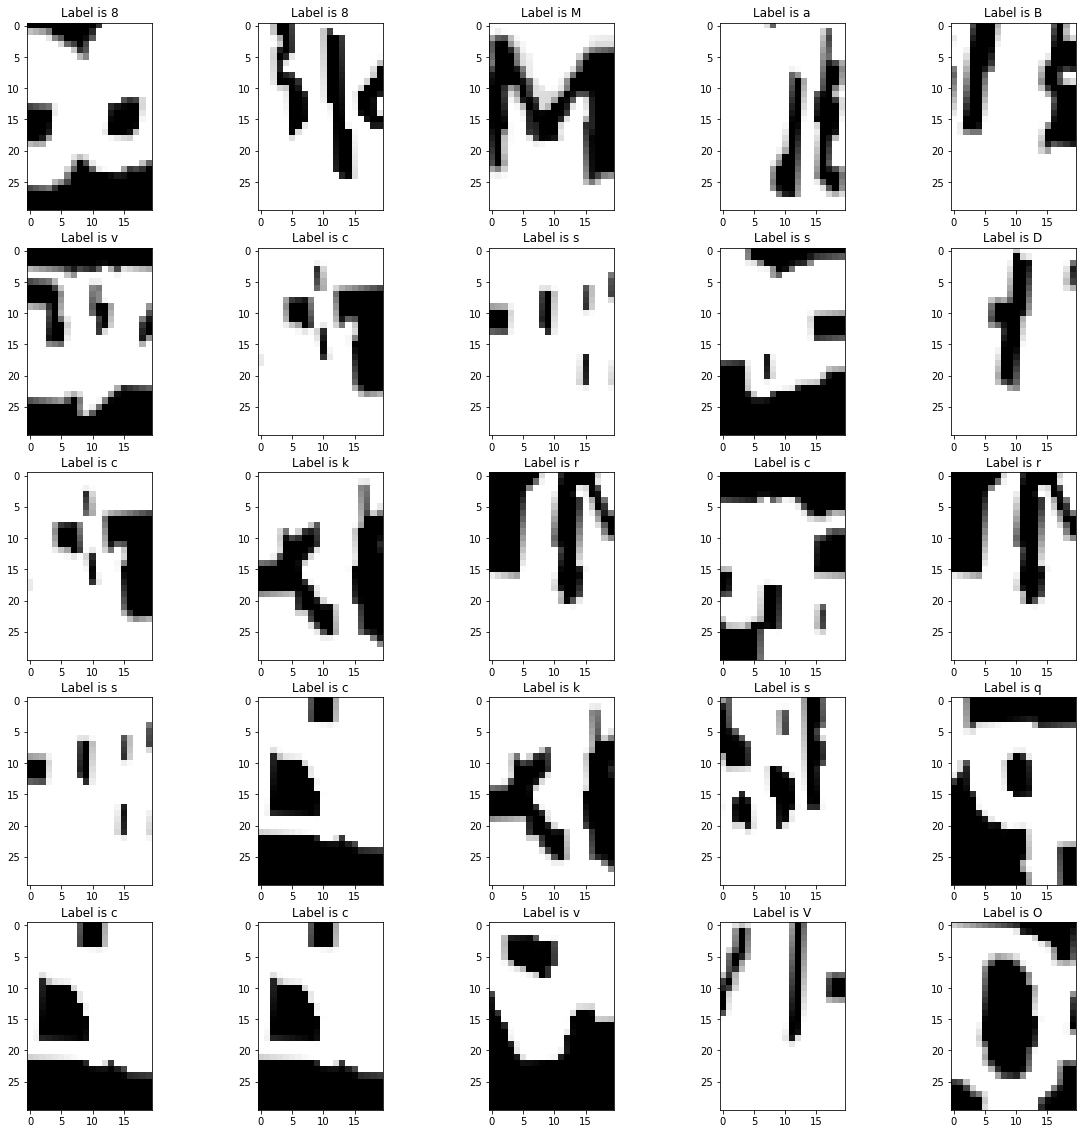

In [164]:
plt.figure(figsize = (20,20))

hi = 32
lo = 0

for i in range(25) :
    plt.subplot(5,5,i+1)
    x = np.random.randint(lo, hi)
    plt.imshow(trainX[x], 'gray')
    plt.title('Label is ' + str(info[np.argmax(trainy[x])]))
plt.show()

# Model Training

In [165]:
model = cnn(128, 32, 16, 32, 32)
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_19 (Sequential)   (None, 15, 10, 128)       1792      
_________________________________________________________________
sequential_20 (Sequential)   (None, 8, 5, 32)          37024     
_________________________________________________________________
sequential_21 (Sequential)   (None, 4, 3, 16)          4688      
_________________________________________________________________
flatten_3 (Flatten)          (None, 192)               0         
_________________________________________________________________
sequential_22 (Sequential)   (None, 32)                6304      
_________________________________________________________________
sequential_23 (Sequential)   (None, 32)                1184      
_________________________________________________________________
dense_11 (Dense)             (None, 60)              

### ModelCheckpoint and ReduceLROnPlateau
Used ModelCheckpoint to retain the best perfroming model (in terms of loss), and ReduceLROnPlateau to reduce the learning in case the model stops improving.

In [166]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkp = ModelCheckpoint('./result_model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)

In [167]:
reduce = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1)

In [168]:
print(X_train.shape)
print(y_train.shape)

(465420, 30, 20, 1)
(465420, 60)


In [169]:
history = model.fit(traingen.flow(X_train, y_train, batch_size = 32), validation_data = (X_test, y_test), epochs = 10, steps_per_epoch = len(X_train)/32, callbacks = [checkp])

Epoch 1/10
14544/14544 [==============================] - 171s 12ms/step - loss: 3.9382 - accuracy: 0.0523 - val_loss: 3.4263 - val_accuracy: 0.1441

Epoch 00001: val_loss improved from inf to 3.42628, saving model to ./result_model.h5
Epoch 2/10
14544/14544 [==============================] - 169s 12ms/step - loss: 3.5210 - accuracy: 0.1241 - val_loss: 3.3229 - val_accuracy: 0.1704

Epoch 00002: val_loss improved from 3.42628 to 3.32287, saving model to ./result_model.h5
Epoch 3/10
14544/14544 [==============================] - 171s 12ms/step - loss: 3.4572 - accuracy: 0.1382 - val_loss: 3.2447 - val_accuracy: 0.1885

Epoch 00003: val_loss improved from 3.32287 to 3.24468, saving model to ./result_model.h5
Epoch 4/10
14544/14544 [==============================] - 171s 12ms/step - loss: 3.4272 - accuracy: 0.1458 - val_loss: 3.2515 - val_accuracy: 0.1856

Epoch 00004: val_loss did not improve from 3.24468
Epoch 5/10
14544/14544 [==============================] - 171s 12ms/step - loss: 3.

Text(0.5, 1.0, 'Model accuracy wrt Epoch')

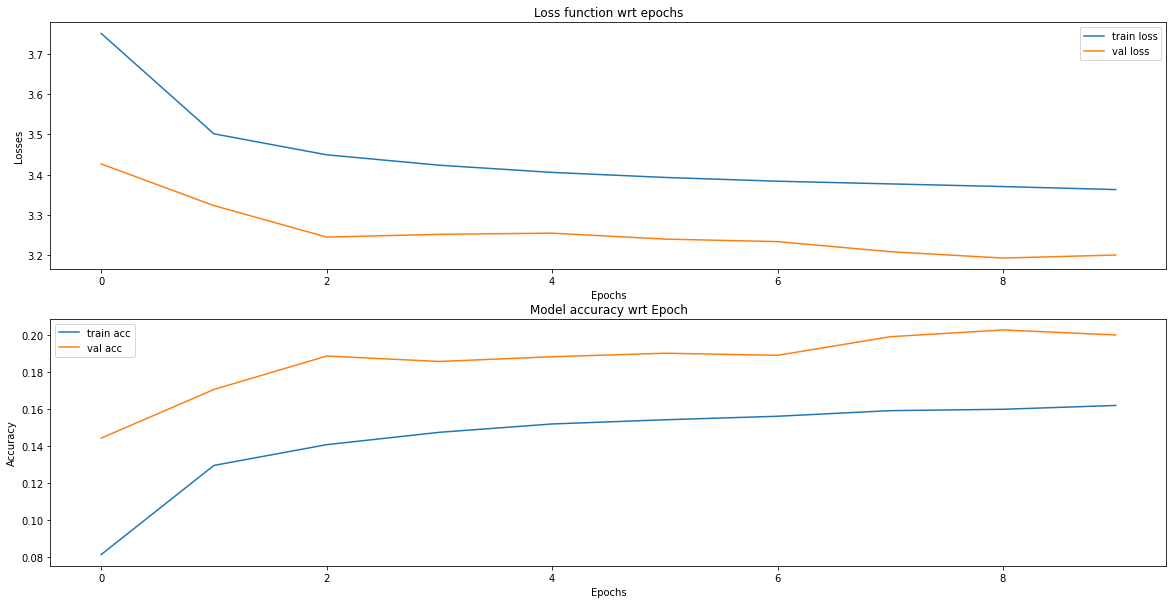

In [179]:
plt.figure(figsize = (20,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['train loss','val loss'])
plt.title('Loss function wrt epochs')

plt.subplot(2,1,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train acc' , 'val acc'])
plt.title('Model accuracy wrt Epoch')

# Prediction

In [180]:
from keras.models import load_model

In [181]:
model = load_model('./result_model.h5')

In [182]:
pred = model.predict(X_test)

Perfromed numpy argmax to obtain the value which has the highest probability of being the truth value.

In [183]:
pred = np.argmax(pred, axis = 1)
yres = np.argmax(y_test,axis= 1)

In [184]:
from sklearn.metrics import accuracy_score, classification_report

In [185]:
target_name = []
for i in sorted(info) :
    target_name.append(info[i])

In [186]:
target_name

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [187]:
print('Accuracy : ' + str(accuracy_score(yres, pred)))
print(classification_report(yres, pred, target_names = target_name))

Accuracy : 0.20264102881604784
              precision    recall  f1-score   support

           1       0.07      0.03      0.04      1966
           2       0.23      0.36      0.28      1804
           3       0.21      0.21      0.21      1901
           4       0.09      0.35      0.14      1884
           5       0.26      0.13      0.17      1927
           6       0.31      0.19      0.24      1901
           7       0.31      0.21      0.25      1932
           8       0.21      0.21      0.21      1913
           9       0.18      0.16      0.17      1889
           A       0.32      0.54      0.40      1878
           B       0.33      0.14      0.19      1897
           C       0.20      0.11      0.14      1899
           D       0.50      0.07      0.13      1946
           E       0.15      0.17      0.16      1865
           F       0.13      0.11      0.12      1902
           G       0.19      0.07      0.10      1870
           H       0.12      0.25      0.16      1